# REINFORCE for text plagiarism detection

In [169]:
import math
import random
from itertools import accumulate

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from cycler import cycler
from torch.utils.data import Dataset
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe
from tqdm import tqdm

In [170]:
torch.cuda.is_available()

True

In [171]:
DEVICE = torch.device("cuda") or torch.device("cpu")
# DEVICE = torch.device("cpu")
DEVICE

device(type='cuda')

## Utilities

In [172]:
GAMMA = 0.99
REWARD_STEPS = 0

In [173]:
def calculate_qvals_(rewards: list[float], gamma: float = GAMMA) -> np.ndarray:
    return np.array(
        list(reversed(list(accumulate(reversed(rewards), lambda x, y: gamma * x + y))))
    )

In [174]:
def calculate_qvals(
    rewards: list[float], gamma: float = GAMMA, reward_steps: int = REWARD_STEPS
) -> np.ndarray:
    rw_steps = reward_steps if reward_steps != 0 else len(rewards)

    return np.array(
        [
            list(
                accumulate(
                    reversed(rewards[i : i + rw_steps]), lambda x, y: gamma * x + y
                )
            )[-1]
            for i in range(len(rewards))
        ]
    )

## Dataset

In [175]:
tokenizer = get_tokenizer("basic_english")
global_vectors = GloVe(cache="../data")


def text_pipeline(x):
    return global_vectors.get_vecs_by_tokens(tokenizer(x), lower_case_backup=True)

Epoch #7:  25%|██▌       | 2/8 [00:17<00:00, 12.27it/s]

In [176]:
def read_from_disk(path: str) -> np.ndarray:
    return pd.read_csv(path).to_numpy()

In [177]:
class PlagiarismDataset(Dataset):
    def __init__(self, data: np.ndarray):
        targets, candidates, enc_targets, enc_candidates, scores = [], [], [], [], []

        for target, candidate, score in data:
            targets.append(tokenizer(target))
            candidates.append(tokenizer(candidate))
            enc_targets.append(text_pipeline(target))
            enc_candidates.append(text_pipeline(candidate))
            scores.append(score)

        self.targets = targets
        self.candidates = candidates
        self.enc_targets = enc_targets
        self.enc_candidates = enc_candidates
        self.scores = np.array(scores).astype(np.float16)

    def __len__(self):
        return len(self.scores)

    def __getitem__(
        self, idx
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, list, list]:
        return (
            self.enc_targets[idx].to(DEVICE),
            self.enc_candidates[idx].to(DEVICE),
            torch.tensor([self.scores[idx]]).float().to(DEVICE),
            self.targets[idx],
            self.candidates[idx],
        )

In [178]:
train_data = PlagiarismDataset(read_from_disk("../generated/datasets/train_sm.csv"))
test_data = PlagiarismDataset(read_from_disk("../generated/datasets/test_sm.csv"))

print(f"{len(train_data)=}")
print(f"{len(test_data)=}")

len(train_data)=2520
len(test_data)=147


In [179]:
EMBED_DIM = int(global_vectors.dim or 0)
LSTM_LAYERS = 1
HIDDEN_SIZE = EMBED_DIM

## RNet & SRModel

In [180]:
class RNetNN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dim: int = 128) -> None:
        super(RNetNN, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.net(x)


class RNet:
    def __init__(self, lr: float = 1e-2, device=DEVICE):
        self.net = RNetNN(2 * LSTM_LAYERS * HIDDEN_SIZE, 1).to(device)
        self.loss_fn = F.mse_loss
        self.optimizer = optim.Adam(
            self.net.parameters(),
            lr=lr,
        )

    def __call__(self, data: torch.Tensor, grad: bool = True) -> torch.Tensor:
        if grad:
            return self.net(data)
        with torch.no_grad():
            return self.net(data)


class SRModelNN(nn.Module):
    def __init__(
        self, input_dim: int, hidden_size: int, num_layers: int = LSTM_LAYERS
    ) -> None:
        super(SRModelNN, self).__init__()

        self.net = nn.LSTM(
            input_dim,
            hidden_size,
            num_layers=num_layers,
            bidirectional=False,
        ).to(DEVICE)

    def forward(self, *x):
        return self.net(*x)


class SRModel:
    def __init__(self, lr: float = 1e-2, device=DEVICE):
        self.net = SRModelNN(EMBED_DIM, HIDDEN_SIZE).to(device)
        self.optimizer = optim.Adam(
            self.net.parameters(),
            lr=lr,
        )

        self.device = device

    def __call__(self, *data, grad: bool = True) -> torch.Tensor:
        if grad:
            return self.net(*data)
        with torch.no_grad():
            return self.net(*data)

    def call_batch(self, data, grad: bool = True) -> torch.Tensor:
        cat_data = torch.cat(data).view(len(data), 1, -1)
        h_c = (
            torch.zeros(LSTM_LAYERS, 1, HIDDEN_SIZE).to(self.device),
            torch.zeros(LSTM_LAYERS, 1, HIDDEN_SIZE).to(self.device),
        )
        out, _ = self.__call__(cat_data, h_c, grad=grad)
        return out[-1].flatten()

In [181]:
rnet = RNet()
srm = SRModel()

In [182]:
def update_sample(
    srm: SRModel,
    rnet: RNet,
    target: list[torch.Tensor],
    candidate: list[torch.Tensor],
    score: float,
    train_srm: bool = True,
    train_rnet: bool = True,
):
    srm_out_target = srm.call_batch(target, train_srm)
    srm_out_candidate = srm.call_batch(candidate, train_srm)

    rnet_out = rnet(
        torch.cat([srm_out_target, srm_out_candidate]).view(1, -1), grad=train_rnet
    )

    return rnet_out.squeeze(-1)


def update_models(
    srm: SRModel,
    rnet: RNet,
    data: list[tuple[list[torch.Tensor], list[torch.Tensor], float]],
    train_srm: bool = True,
    train_rnet: bool = True,
) -> float:
    srm.net.train(train_srm)
    rnet.net.train(train_rnet)

    srm.optimizer.zero_grad()
    rnet.optimizer.zero_grad()

    predicts = []
    scores = []

    for target, candidate, score in data:
        predicted = update_sample(
            srm, rnet, target, candidate, score, train_srm, train_rnet
        )
        scores.append(score)
        predicts.append(predicted)

    score_tensor = torch.FloatTensor(scores).to(DEVICE)
    loss = rnet.loss_fn(torch.cat(predicts), score_tensor)

    loss.backward()
    srm.optimizer.step()
    rnet.optimizer.step()

    srm.net.train(False)
    rnet.net.train(False)

    return loss.item()

## Environment

In [183]:
class Env:
    def _get_state(self) -> torch.Tensor:
        token = self.data[self.sentence_idx][self.token_idx]
        return torch.cat(
            [
                self.hs[self.sentence_idx].flatten(),
                self.cs[self.sentence_idx].flatten(),
                token,
            ]
        ).to(DEVICE)

    def _get_reward(self) -> float:
        if not self.is_terminal():
            return 0.0

        rnet_out = self.rnet(self.hs.view(1, -1), grad=False)

        score_tensor = torch.FloatTensor([self.data[2]]).to(DEVICE)
        loss = self.rnet.loss_fn(rnet_out.squeeze(-1), score_tensor)
        self.loss = loss.item()

        return -np.log(loss.item() + 1e-8) + self.gamma * self.deleted / self.total_words

    def __init__(
        self,
        dataset: Dataset,
        srm: SRModel,
        rnet: RNet,
        gamma: float = 0.05,
        random_sampling: bool = True,
    ) -> None:
        self.srm = srm
        self.rnet = rnet

        self.gamma = gamma

        self.dataset = dataset

        self.random_sampling = random_sampling
        self.idx = -1

        self.reset()

    def reset(self, idx: int = -1) -> torch.Tensor:
        self.loss = -1

        self.steps = 0

        self.sentence_idx = 0
        self.token_idx = 0

        if self.random_sampling:
            self.idx = np.random.randint(len(self.dataset))
        elif idx >= 0:
            self.idx = idx
        else:
            self.idx = (self.idx + 1) % len(self.dataset)

        self.data = self.dataset[self.idx]

        self.total_words = len(self.data[0]) + len(self.data[1])
        self.deleted = 0

        self.hs = torch.zeros((2, LSTM_LAYERS, HIDDEN_SIZE)).to(DEVICE)
        self.cs = torch.zeros((2, LSTM_LAYERS, HIDDEN_SIZE)).to(DEVICE)

        self.used_tokens: list[list[torch.Tensor]] = [[], []]

        return self.get_state()

    def get_state(self) -> torch.Tensor:
        return self._get_state()

    def is_terminal(self) -> bool:
        return self.sentence_idx == 1 and self.token_idx == (len(self.data[1]) - 1)

    def interact(self, action: int) -> tuple[torch.Tensor, float, bool]:
        # 0 - retain
        # 1 - delete

        if self.is_terminal():
            return self._get_state(), 0, self.is_terminal()

        if action == 1:
            self.deleted += 1

        elif action == 0:
            token = self.data[self.sentence_idx][self.token_idx]
            self.used_tokens[self.sentence_idx].append(token.clone().detach())

            h_c = (
                self.hs[self.sentence_idx].clone().detach(),
                self.cs[self.sentence_idx].clone().detach(),
            )

            _, (h, c) = self.srm(token.view(1, -1), h_c, grad=False)
            self.hs[self.sentence_idx] = h.clone().detach()
            self.cs[self.sentence_idx] = c.clone().detach()

        self.steps += 1
        self.token_idx += 1
        if self.sentence_idx == 0 and self.token_idx >= len(self.data[0]):
            self.sentence_idx = 1
            self.token_idx = 0

        return self._get_state(), self._get_reward(), self.is_terminal()

    def get_tokens_info(self) -> tuple[list[torch.Tensor], list[torch.Tensor], float]:
        target_tokens, candidate_tokens = self.used_tokens
        return (target_tokens, candidate_tokens, self.data[2].item())

    def get_observation_shape(self) -> int:
        return 2 * LSTM_LAYERS * HIDDEN_SIZE + EMBED_DIM

    def get_actions_shape(self) -> int:
        return 2

In [184]:
_env = Env(test_data, srm, rnet)

## Policy Gradient Network

In [185]:
class PGN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dim: int = 16) -> None:
        super(PGN, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x):
        return self.net(x)

## Agent

In [186]:
class Agent:
    def choose_action(self, action_logits):
        return random.choices(range(len(action_logits)), F.softmax(action_logits, dim=0))[
            0
        ]

    def choose_optimal_action(self, action_logits) -> int:
        return int(np.argmax(F.softmax(action_logits, dim=0).cpu()).item())

## Trajectory Buffer

In [187]:
class TrajectoryBuffer:
    """
    Buffer class to store the experience from a unique policy
    """

    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.discounted_rewards = []
        self.discounted_baseline_rewards = []

        self.tokens_data = []

    def store(
        self,
        states_trajectory: np.ndarray,
        trajectory: np.ndarray,
        tokens_info: tuple[list[torch.Tensor], list[torch.Tensor], float],
    ):
        """
        Add trajectory values to the buffers and compute the advantage and reward to go

        Parameters:
        -----------
        states_trajectory:  list that contains states
        trajectory: list where each element is a list that contains: reward, action
        tokens_info: (target_tokens, candidate_tokens, score)
        """
        assert len(states_trajectory) == len(trajectory)

        if len(states_trajectory) > 0:
            self.tokens_data.append(tokens_info)

            self.states.extend(states_trajectory)
            self.rewards.extend(trajectory[:, 0])
            discounted_rewards = calculate_qvals(trajectory[:, 0])

            # BASELINE
            # b = trajectory[:,0].mean() # avg for rewards in trajectory
            # b = np.mean(self.rewards)  # avg for all rewards in episode
            # b = np.mean(discounted_rewards)  #

            self.actions.extend(trajectory[:, 1])
            self.discounted_rewards.extend(discounted_rewards)
            # self.discounted_baseline_rewards.extend(discounted_rewards - b)
            # self.discounted_baseline_rewards.extend((discounted_rewards - np.mean(discounted_rewards))/(np.std(discounted_rewards) + 1e-10))

    def get_batch(self):
        # return self.states, self.actions, self.discounted_baseline_rewards
        return self.states, self.actions, self.discounted_rewards, self.tokens_data

    def __len__(self):
        assert (
            len(self.states) == len(self.actions) == len(self.discounted_rewards)
            # == len(self.discounted_baseline_rewards)
        )
        return len(self.states)

## Evaluation

In [188]:
def evaluate(
    srm: SRModel,
    rnet: RNet,
    pgn: nn.Module,
    agent: Agent,
    data: Dataset,
) -> list[float]:
    srm.net.eval()
    rnet.net.eval()
    pgn.eval()

    losses = []

    eval_env = Env(data, srm, rnet, random_sampling=False)

    iteration = 0
    state = eval_env.reset(0)
    with tqdm(total=len(data), desc="Evaluation") as loop:
        while iteration < len(data):
            with torch.no_grad():
                action_logits = pgn(state)

            action = agent.choose_optimal_action(action_logits)
            state2, _, done = eval_env.interact(action)
            state = state2.clone().detach()

            if done:
                iteration += 1
                losses.append(eval_env.loss)
                state = eval_env.reset()

                loop.update(1)
                loop.set_postfix(
                    {
                        "Mean Test loss": np.mean(losses),
                    }
                )
    return losses

## Training

In [189]:
LEARNING_RATE = 0.005

np.random.seed(42)
torch.manual_seed(42)

env = Env(train_data, srm, rnet)
pgn = PGN(input_dim=env.get_observation_shape(), output_dim=env.get_actions_shape()).to(
    DEVICE
)
agent = Agent()
optimizer = optim.Adam(pgn.parameters(), lr=LEARNING_RATE)

In [190]:
EPOCHS = 100
EPISODES_PER_EPOCH = 8
EVAL_PERIOD = 10

CLIP_GRAD = 0.1
ENTROPY_BETA = 0.01

In [191]:
step_count = 0
train_rewards = []
train_ep_len = []

mean_epoch_rewards = []
mean_epoch_ep_len = []
epoch_loss = []
epoch_entropy = []

epoch_mean_test_losses = []
eval_epochs = []

epoch_models_loss = []


probs = []


for i in range(1, EPOCHS + 1):
    state = env.reset()
    buffer = TrajectoryBuffer()
    env_states_buf, env_rew_act_buf = [], []
    ep_rewards = []

    train_logs_shift = len(train_rewards)  # for logging
    done_episodes = 0

    epoch_loop = tqdm(total=EPISODES_PER_EPOCH, desc=f"Epoch #{i}", position=0)
    while done_episodes < EPISODES_PER_EPOCH:
        with torch.no_grad():
            action_logits = pgn(state)

        action = agent.choose_action(action_logits)
        state2, reward, done = env.interact(action)

        env_states_buf.append(state.cpu().clone().detach().numpy())
        env_rew_act_buf.append([reward, int(action)])

        state = state2.clone().detach()

        step_count += 1
        ep_rewards.append(reward)

        if done:
            buffer.store(
                np.array(env_states_buf), np.array(env_rew_act_buf), env.get_tokens_info()
            )
            env_states_buf, env_rew_act_buf = [], []

            train_rewards.append(np.sum(ep_rewards))
            train_ep_len.append(len(ep_rewards))

            state = env.reset()
            ep_rewards = []
            done_episodes += 1
            epoch_loop.update(1)

    state_batch, action_batch, reward_batch, tokens_data = buffer.get_batch()

    # baseline
    # reward_batch -= np.mean(buffer.discounted_rewards)
    # reward_batch = np.array(reward_batch) - np.mean(buffer.discounted_rewards)

    # Update RNet & SRModel
    models_loss = update_models(env.srm, env.rnet, tokens_data)

    # Update PGN
    optimizer.zero_grad()
    states_t = torch.FloatTensor(np.array(state_batch)).to(DEVICE)
    batch_actions_t = torch.LongTensor(action_batch).to(DEVICE)
    batch_qvals_t = torch.FloatTensor(reward_batch).to(DEVICE)

    logits_v = pgn(states_t)
    log_prob_v = F.log_softmax(logits_v, dim=1)

    log_prob_actions_v = batch_qvals_t * log_prob_v[range(len(states_t)), batch_actions_t]
    loss_policy_v = -log_prob_actions_v.mean()

    prob_v = F.softmax(logits_v, dim=1)
    entropy_v = (prob_v * log_prob_v).sum(dim=1).mean()
    entropy_loss_v = ENTROPY_BETA * entropy_v
    loss_v = loss_policy_v + entropy_loss_v

    loss_v.backward()

    nn.utils.clip_grad_norm_(pgn.parameters(), CLIP_GRAD)
    optimizer.step()

    # logging
    probs.append(prob_v.detach().cpu().numpy())
    mean_epoch_rewards.append(np.mean(train_rewards[train_logs_shift:]))
    mean_epoch_ep_len.append(np.mean(train_ep_len[train_logs_shift:]))
    epoch_loss.append(loss_v.item())
    epoch_entropy.append(-entropy_v.item())
    epoch_models_loss.append(models_loss)

    epoch_loop.set_postfix(
        {
            "Mean reward": mean_epoch_rewards[-1],
            "Mean PGN Loss": epoch_loss[-1],
            "Mean Entropy": epoch_entropy[-1],
            "Mean RNet Loss": epoch_models_loss[-1],
        }
    )
    epoch_loop.close()

    # evaluate
    if i % EVAL_PERIOD == 0 or i == EPOCHS:
        test_losses = evaluate(srm, rnet, pgn, agent, test_data)
        epoch_mean_test_losses.append(np.mean(test_losses))
        eval_epochs.append(i)

Epoch #1:  38%|███▊      | 3/8 [00:00<00:01,  3.56it/s]

Evaluation: 100%|██████████| 147/147 [00:19<00:00,  7.67it/s, Mean Test loss=0.157]


## Analysis

In [192]:
PREDEFINED_COLORS = [
    "#ffa500",
    "#c83cbc",
    "#1c1c84",
    "#ff0000",
    "#08a4a7",
    "#008000",
]


def draw_plots(
    data_dict: dict,
    title: str,
    plots: list[tuple[dict, dict, list[str]]],
    ylim=None,
    row_plots: int = 1,
    plot_width: float = 12,  # 16
    plot_height: float = 7,  # 7
    use_rainbow: bool = False,
    use_common_legend: bool = False,
    adjust: bool = False,
):
    num_plots = len(plots)
    num_entities = max([len(x[2]) for x in plots]) + 1
    if use_rainbow:
        num_colors = num_entities
        cm = plt.get_cmap("gist_rainbow")
        colors = [cm(1.0 * i / num_colors) for i in range(num_colors)]
    else:
        colors = PREDEFINED_COLORS

    style_cycler = cycler(linestyle=["-", "--", ":", "-."]) * cycler(color=colors)
    column_plots = math.ceil(num_plots / row_plots)

    fig, axs = plt.subplots(
        column_plots,
        row_plots,
        figsize=(plot_width * row_plots, plot_height * column_plots),
    )

    fig.suptitle(title, fontsize=14, y=1)
    axs_list = [axs] if column_plots * row_plots == 1 else list(axs.flat)

    for ax in axs_list:
        ax.grid()
        ax.set_prop_cycle(style_cycler)
        if ylim is not None:
            ax.set_ylim(top=ylim)
        ax.set_visible(False)

    for ax, (p1, p2, vs) in zip(axs_list, plots):
        ax.set_visible(True)

        ax.set_title(f"{p2['name']} over {p1['name']}")
        ax.set(xlabel=p1["label"], ylabel=p2["label"])

        if p1.get("log", False):
            ax.set_xscale("log")
        if p2.get("log", False):
            ax.set_yscale("log")

        x_values = data_dict[p1.get("ref", None) or p1["name"]]
        y_values = data_dict[p2.get("ref", None) or p2["name"]]

        ax.plot(x_values, y_values, label=p2["name"])
        ax.scatter(x_values[-1], y_values[-1], s=15)

        for v in vs:
            ax.plot(x_values, [data_dict[v]] * len(x_values), label=v)

    if use_common_legend:
        lines_labels = [axs_list[0].get_legend_handles_labels()]
        lines, labels = [sum(x, []) for x in zip(*lines_labels)]
        fig.legend(
            lines,
            labels,
            scatterpoints=1,
            markerscale=3,
            loc="outside lower center",
            ncol=min(6, num_entities),
            bbox_to_anchor=(0.5, -0.05),
        )
    else:
        if num_entities > 1:
            for ax, _ in zip(axs_list, plots):
                ax.legend()

    plt.tight_layout()
    if adjust:
        plt.subplots_adjust(
            top=1 - 0.1 / (num_plots**0.5), bottom=0.12 / (num_plots**2), hspace=0.15
        )
    plt.show()

In [195]:
def get_uniform_entropy(n_actions: int):
    probs = np.array([1 / n_actions for _ in range(n_actions)])
    return -np.sum(probs * np.log(probs))


def moving_average(x, w=min(10, EPOCHS)):
    return scipy.signal.savgol_filter(x, w, min(3, w - 1))


uniform_entropy = get_uniform_entropy(env.get_actions_shape())
uniform_entropy

0.6931471805599453

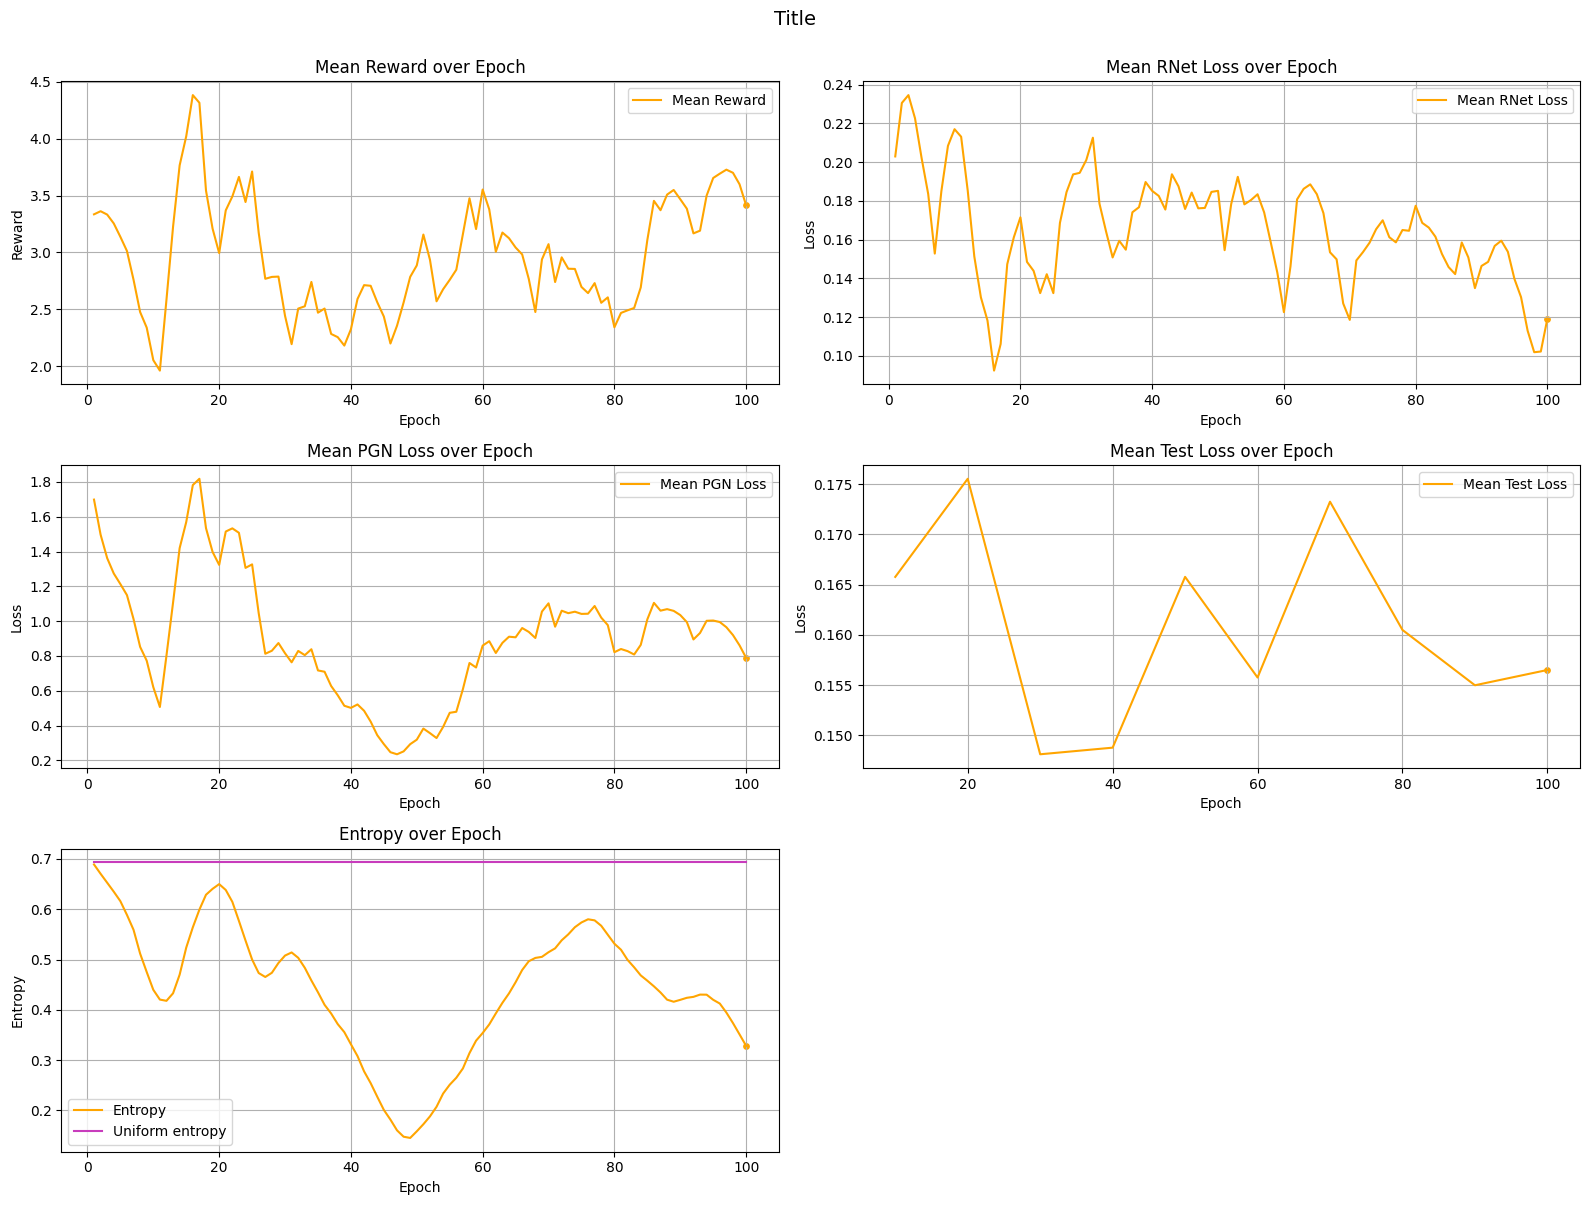

In [198]:
plots_data = {
    "Epoch": list(range(1, EPOCHS + 1)),
    "Eval Epoch": eval_epochs,
    "Mean Reward": moving_average(mean_epoch_rewards),
    "Mean RNet Loss": moving_average(epoch_models_loss),
    "Mean PGN Loss": moving_average(epoch_loss),
    "Mean Test Loss": epoch_mean_test_losses,
    "Entropy": moving_average(epoch_entropy),
    "Uniform entropy": uniform_entropy,
}

plots = [
    (
        {"name": "Epoch", "label": "Epoch"},
        {"name": "Mean Reward", "label": "Reward"},
        [],
    ),
    (
        {"name": "Epoch", "label": "Epoch"},
        {"name": "Mean RNet Loss", "label": "Loss"},
        [],
    ),
    ({"name": "Epoch", "label": "Epoch"}, {"name": "Mean PGN Loss", "label": "Loss"}, []),
    (
        {"name": "Epoch", "label": "Epoch", "ref": "Eval Epoch"},
        {"name": "Mean Test Loss", "label": "Loss"},
        [],
    ),
    (
        {"name": "Epoch", "label": "Epoch"},
        {"name": "Entropy", "label": "Entropy"},
        ["Uniform entropy"],
    ),
]

draw_plots(
    plots_data,
    "Title",
    plots,
    plot_width=8,
    plot_height=4,
    row_plots=2,
)